# Pipeline API - Data Exploration & Research

This notebook demonstrates how to use Zipline's Pipeline API for:
- Querying and exploring stock data
- Building custom factors
- Filtering and screening stocks
- Analyzing factor distributions

Pipeline is perfect for research and factor development before building a strategy.

In [1]:
# Register Sharadar bundle (required for Jupyter notebooks)
from zipline.data.bundles import register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle

register('sharadar', sharadar_bundle(tickers=None, incremental=True, include_funds=True))
print("✓ Sharadar bundle registered")

✓ Sharadar bundle registered


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import (
    Returns,
    SimpleMovingAverage,
    AverageDollarVolume,
    RSI,
)
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.data.bundles import load

# Set plot style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Imports complete")

✓ Imports complete


## Setup Pipeline Environment

To run Pipeline standalone (without a backtest), we need to set up the data bundle.

In [3]:
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.data.data_portal import DataPortal

# Load the bundle
bundle_data = load('sharadar')

# Get trading calendar
trading_calendar = get_calendar('XNYS')

# Create pricing loader
pricing_loader = USEquityPricingLoader.without_fx(
    bundle_data.equity_daily_bar_reader,
    bundle_data.adjustment_reader,
)

# Create pipeline engine
def make_engine():
    return SimplePipelineEngine(
        get_loader=lambda column: pricing_loader,
        asset_finder=bundle_data.asset_finder,
    )

engine = make_engine()

print("✓ Pipeline engine initialized")
print(f"  Available date range: {bundle_data.equity_daily_bar_reader.first_trading_day} to {bundle_data.equity_daily_bar_reader.last_available_dt}")

✓ Pipeline engine initialized
  Available date range: 1998-01-02 00:00:00 to 2026-11-18 00:00:00


## Example 1: Basic Pipeline - Query Stock Data

Let's create a simple pipeline to get price and volume data.

In [4]:
# Define date range for research - ensure dates are valid trading days
all_sessions = trading_calendar.sessions

# Get valid trading dates
desired_start = pd.Timestamp('2023-01-01')
desired_end = pd.Timestamp('2023-12-31')

start_date = all_sessions[all_sessions >= desired_start][0]
end_date = all_sessions[all_sessions <= desired_end][-1]

# Create a simple pipeline
def make_basic_pipeline():
    # Get closing price and volume
    close = USEquityPricing.close.latest
    volume = USEquityPricing.volume.latest
    
    # Calculate dollar volume (liquidity measure)
    dollar_volume = AverageDollarVolume(window_length=30)
    
    # Filter for liquid stocks (top 500 by dollar volume)
    liquid = dollar_volume.top(500)
    
    return Pipeline(
        columns={
            'close': close,
            'volume': volume,
            'dollar_volume': dollar_volume,
        },
        screen=liquid
    )

# Run the pipeline for a single day
pipeline = make_basic_pipeline()
result = engine.run_pipeline(pipeline, start_date, start_date)

print(f"✓ Pipeline returned {len(result)} stocks on {start_date.date()}")
print("\nSample data:")
result.head(10)

✓ Pipeline returned 500 stocks on 2023-01-03

Sample data:


close      volume  dollar_volume
2023-01-03 Equity(108471 [COSM])    4.56   2684000.0   1.596988e+08
           Equity(110316 [BILL])  108.96   1104456.0   1.765471e+08
           Equity(110495 [BNTX])  150.22    934450.0   1.612313e+08
           Equity(110534 [DDOG])   73.50   2168241.0   2.901475e+08
           Equity(110553 [NET])    45.21   2465988.0   2.165294e+08
           Equity(110725 [CRWD])  105.29   3131739.0   6.746364e+08
           Equity(110757 [CTVA])   56.97   1858000.0   1.623593e+08
           Equity(110813 [DKNG])   11.39  11399294.0   1.748301e+08
           Equity(110842 [UBER])   24.73  20446648.0   4.914312e+08
           Equity(110958 [ZM])     67.74   1864196.0   2.886239e+08

## Example 2: Custom Factors - Momentum and Volatility

Create custom factors for momentum and volatility analysis.

In [5]:
class Momentum(CustomFactor):
    """
    Price momentum: % return over lookback period.
    """
    inputs = [USEquityPricing.close]
    window_length = 60
    
    def compute(self, today, assets, out, close):
        out[:] = (close[-1] - close[0]) / close[0]


class Volatility(CustomFactor):
    """
    Price volatility: standard deviation of returns.
    """
    inputs = [USEquityPricing.close]
    window_length = 20
    
    def compute(self, today, assets, out, close):
        returns = np.diff(close, axis=0) / close[:-1]
        out[:] = np.std(returns, axis=0)


class MeanReversion(CustomFactor):
    """
    Mean reversion: % deviation from moving average.
    """
    inputs = [USEquityPricing.close]
    window_length = 20
    
    def compute(self, today, assets, out, close):
        ma = np.mean(close, axis=0)
        out[:] = (close[-1] - ma) / ma


print("✓ Custom factors defined")

✓ Custom factors defined


In [6]:
# Create pipeline with custom factors
def make_research_pipeline():
    # Calculate factors
    momentum = Momentum()
    volatility = Volatility()
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    rsi = RSI()
    
    # Universe: top 500 liquid stocks
    universe = dollar_volume.top(500)
    
    # Normalize factors to z-scores
    momentum_z = momentum.zscore(mask=universe)
    volatility_z = volatility.zscore(mask=universe)
    
    return Pipeline(
        columns={
            'close': USEquityPricing.close.latest,
            'momentum': momentum,
            'volatility': volatility,
            'mean_reversion': mean_reversion,
            'rsi': rsi,
            'momentum_z': momentum_z,
            'volatility_z': volatility_z,
            'dollar_volume': dollar_volume,
        },
        screen=universe
    )

# Run pipeline over a period
pipeline = make_research_pipeline()
results = engine.run_pipeline(pipeline, start_date, end_date)

print(f"✓ Pipeline returned {len(results)} stock-date observations")
print(f"  Date range: {results.index.get_level_values(0).min()} to {results.index.get_level_values(0).max()}")
print(f"  Unique stocks: {results.index.get_level_values(1).nunique()}")
print("\nFactor statistics:")
results[['momentum', 'volatility', 'mean_reversion', 'rsi']].describe()

✓ Pipeline returned 125000 stock-date observations
  Date range: 2023-01-03 00:00:00 to 2023-12-29 00:00:00
  Unique stocks: 739

Factor statistics:


,momentum,volatility,mean_reversion,rsi
count,124859.000000,124954.000000,124954.000000,124999.000000
mean,0.040971,0.019144,0.005827,52.739928
std,0.215104,0.017377,0.063664,18.201183
min,-0.976122,0.000096,-0.864806,0.000000
25%,-0.055820,0.010654,-0.022162,39.348256
50%,0.019307,0.015297,0.004557,52.767434
75%,0.111127,0.022446,0.032775,66.081219
max,5.666667,0.672764,0.953609,100.000000


## Example 3: Factor Distribution Analysis

Analyze the distribution of factors across the universe.

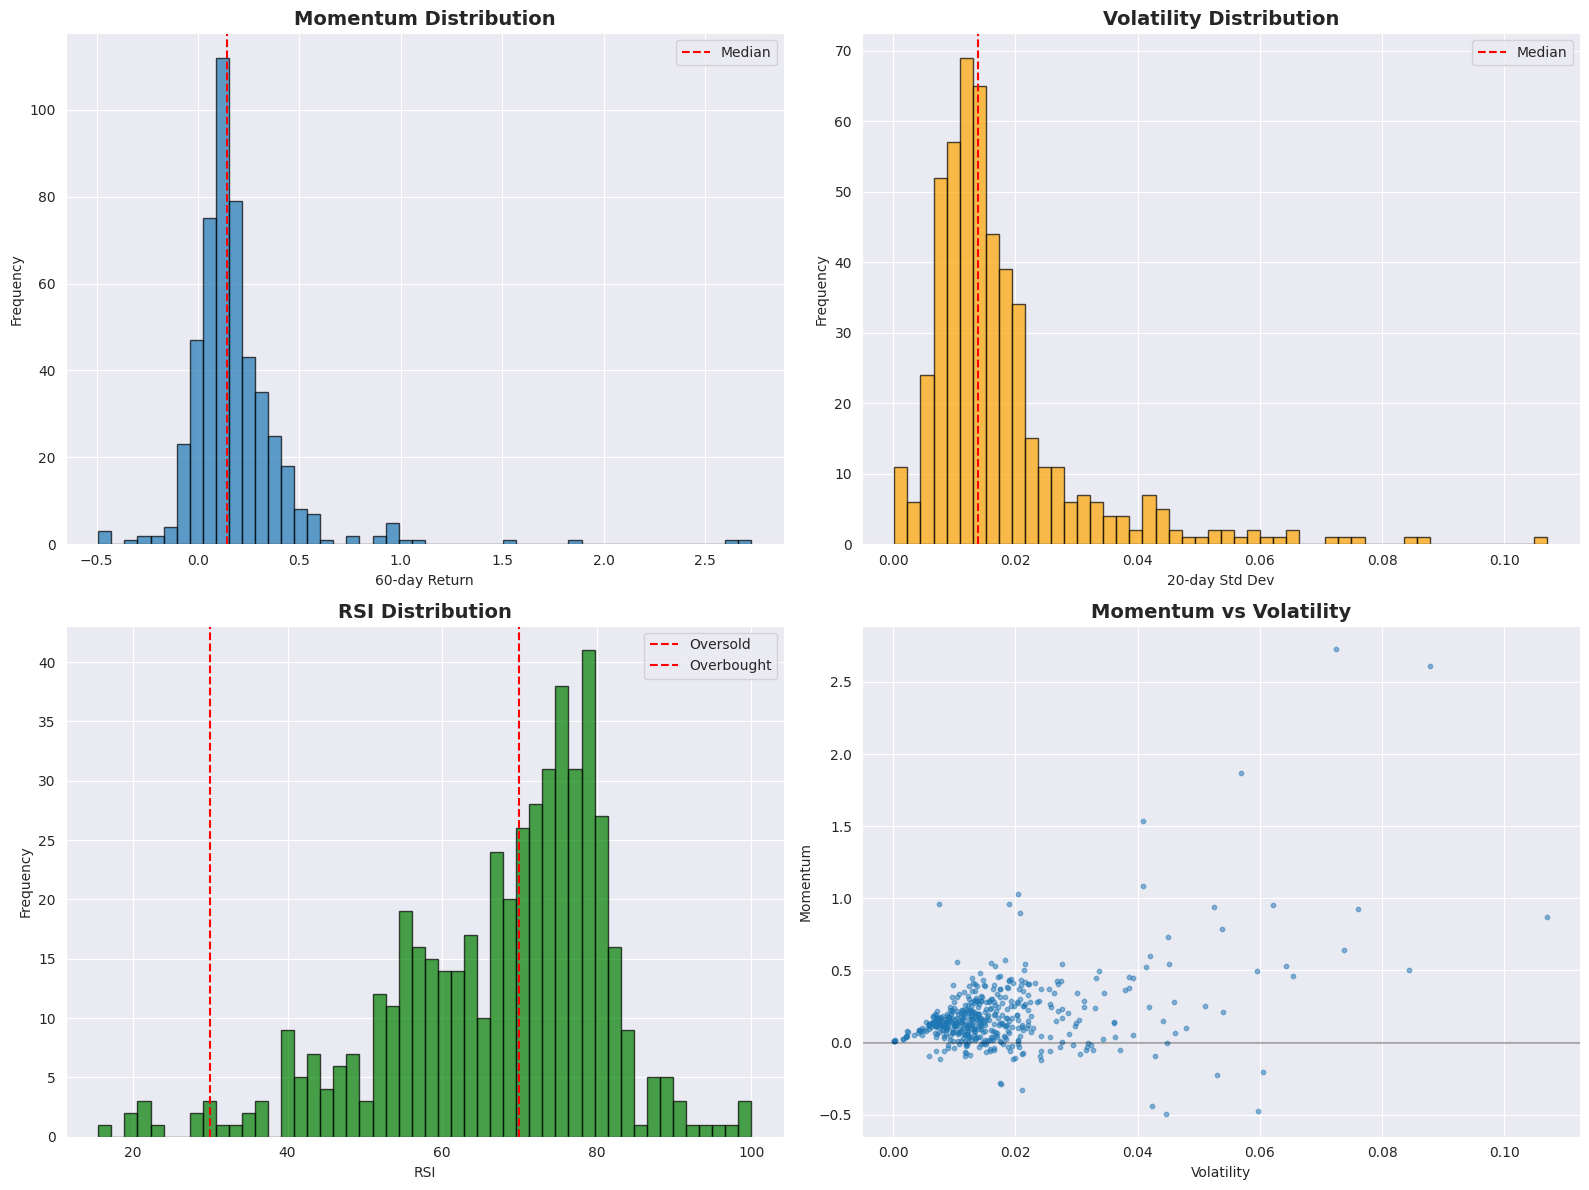

In [7]:
# Get latest date data
latest_date = results.index.get_level_values(0).max()
latest_data = results.loc[latest_date]

# Plot factor distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Momentum distribution
axes[0, 0].hist(latest_data['momentum'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Momentum Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('60-day Return')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(latest_data['momentum'].median(), color='red', linestyle='--', label='Median')
axes[0, 0].legend()

# Volatility distribution
axes[0, 1].hist(latest_data['volatility'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Volatility Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('20-day Std Dev')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(latest_data['volatility'].median(), color='red', linestyle='--', label='Median')
axes[0, 1].legend()

# RSI distribution
axes[1, 0].hist(latest_data['rsi'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title('RSI Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('RSI')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(30, color='red', linestyle='--', label='Oversold')
axes[1, 0].axvline(70, color='red', linestyle='--', label='Overbought')
axes[1, 0].legend()

# Momentum vs Volatility scatter
scatter_data = latest_data[['momentum', 'volatility']].dropna()
axes[1, 1].scatter(scatter_data['volatility'], scatter_data['momentum'], alpha=0.5, s=10)
axes[1, 1].set_title('Momentum vs Volatility', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Volatility')
axes[1, 1].set_ylabel('Momentum')
axes[1, 1].axhline(0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

## Example 4: Factor Correlation Analysis

Understand how factors relate to each other.

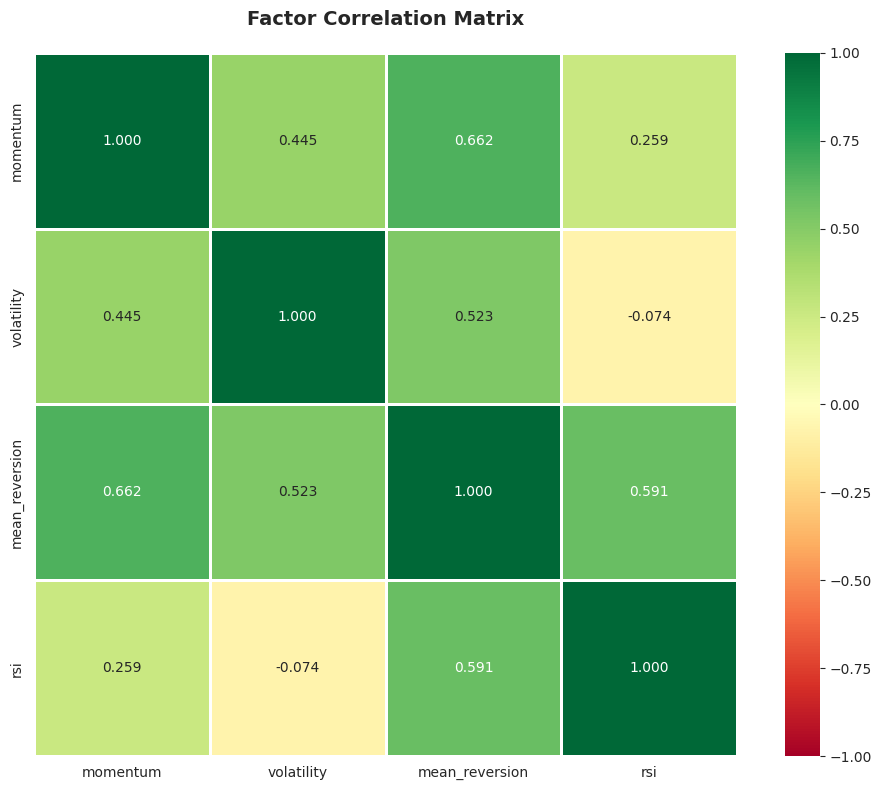


Factor Correlations:
                momentum  volatility  mean_reversion       rsi
momentum        1.000000    0.445075        0.662194  0.258615
volatility      0.445075    1.000000        0.522680 -0.074117
mean_reversion  0.662194    0.522680        1.000000  0.590995
rsi             0.258615   -0.074117        0.590995  1.000000


In [8]:
# Calculate factor correlations
factor_cols = ['momentum', 'volatility', 'mean_reversion', 'rsi']
correlations = latest_data[factor_cols].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlations,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=1
)
plt.title('Factor Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nFactor Correlations:")
print(correlations)

## Example 5: Quintile Analysis

Divide stocks into quintiles based on a factor and analyze characteristics.


Momentum Quintile Analysis:
                   momentum                 volatility                  \
                       mean    median count       mean    median count   
momentum_quintile                                                        
Q1 (Low)          -0.042382 -0.011365   100   0.018104  0.015495   100   
Q2                 0.082163  0.081633   100   0.012863  0.011266   100   
Q3                 0.142534  0.140341   100   0.012694  0.010680   100   
Q4                 0.223724  0.221238   100   0.016304  0.013870   100   
Q5 (High)          0.530105  0.406096   100   0.027231  0.019408   100   

                         rsi                  dollar_volume                \
                        mean     median count          mean        median   
momentum_quintile                                                           
Q1 (Low)           59.319217  59.878001   100  8.392557e+08  3.416783e+08   
Q2                 65.277078  66.893235   100  5.849856e+08  3.456798e

/tmp/ipykernel_939/885568711.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_analysis = latest_data.groupby('momentum_quintile')[


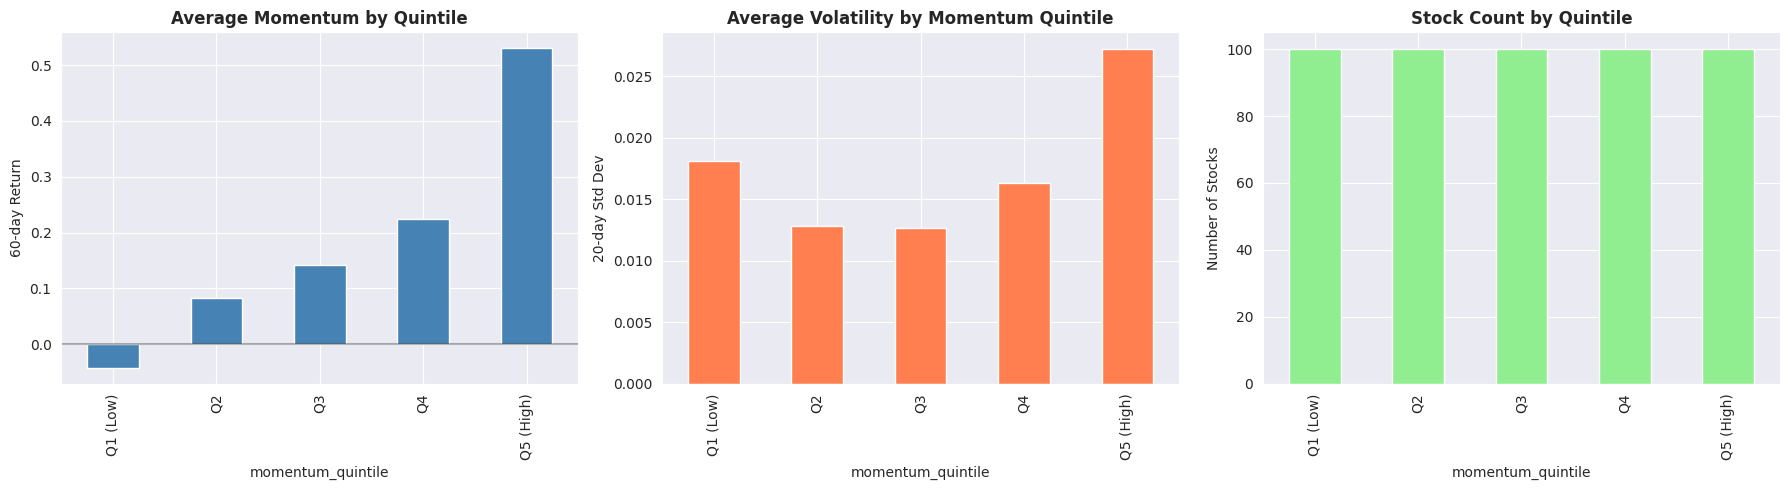

In [9]:
# Divide into quintiles based on momentum
latest_data['momentum_quintile'] = pd.qcut(
    latest_data['momentum'],
    q=5,
    labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4', 'Q5 (High)'],
    duplicates='drop'
)

# Analyze characteristics by quintile
quintile_analysis = latest_data.groupby('momentum_quintile')[
    ['momentum', 'volatility', 'rsi', 'dollar_volume']
].agg(['mean', 'median', 'count'])

print("\nMomentum Quintile Analysis:")
print("="*80)
print(quintile_analysis)

# Visualize quintiles
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Average momentum by quintile
quintile_analysis['momentum']['mean'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Average Momentum by Quintile', fontsize=12, fontweight='bold')
axes[0].set_ylabel('60-day Return')
axes[0].axhline(0, color='black', linestyle='-', alpha=0.3)

# Average volatility by quintile
quintile_analysis['volatility']['mean'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Average Volatility by Momentum Quintile', fontsize=12, fontweight='bold')
axes[1].set_ylabel('20-day Std Dev')

# Stock count by quintile
quintile_analysis['momentum']['count'].plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Stock Count by Quintile', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Number of Stocks')

plt.tight_layout()
plt.show()

## Example 6: Stock Screening

Use Pipeline to screen for specific stock characteristics.

In [10]:
# Screen for stocks with:
# - High momentum (top 20%)
# - Low volatility (bottom 50%)
# - RSI not overbought (< 70)

high_momentum = latest_data['momentum'] > latest_data['momentum'].quantile(0.80)
low_volatility = latest_data['volatility'] < latest_data['volatility'].quantile(0.50)
not_overbought = latest_data['rsi'] < 70

screened_stocks = latest_data[high_momentum & low_volatility & not_overbought]

print(f"\n✓ Screen found {len(screened_stocks)} stocks")
print("\nTop 10 Screened Stocks:")
print("="*80)

# Show top stocks sorted by momentum
top_stocks = screened_stocks.nlargest(10, 'momentum')
display_cols = ['close', 'momentum', 'volatility', 'rsi', 'dollar_volume']
print(top_stocks[display_cols].to_string())

# Get asset symbols
print("\nStock Symbols:")
for asset in top_stocks.index:
    symbol = bundle_data.asset_finder.retrieve_asset(asset.sid).symbol
    momentum = top_stocks.loc[asset, 'momentum']
    volatility = top_stocks.loc[asset, 'volatility']
    print(f"  {symbol:<10} Momentum: {momentum:>7.2%}  Volatility: {volatility:>6.4f}")


✓ Screen found 9 stocks

Top 10 Screened Stocks:
                          close  momentum  volatility        rsi  dollar_volume
Equity(198080 [IMGN])    29.710  0.959763    0.007505  56.159420   2.616676e+08
Equity(110842 [UBER])    63.140  0.404984    0.013465  62.918660   2.188918e+09
Equity(196669 [AMT])    204.919  0.402201    0.009785  68.143530   4.197624e+08
Equity(198325 [FICO])  1169.340  0.358355    0.013410  68.753657   2.014849e+08
Equity(199795 [TGT])    132.386  0.350175    0.011652  66.896040   6.243119e+08
Equity(194807 [WDAY])   276.080  0.318623    0.010416  56.523272   5.406983e+08
Equity(196696 [CCI])    105.433  0.318423    0.009563  50.214592   4.049572e+08
Equity(198215 [C])       48.313  0.310361    0.013613  69.977427   7.954269e+08
Equity(198666 [IT])     452.270  0.302246    0.012352  54.797246   2.093037e+08

Stock Symbols:
  IMGN       Momentum:  95.98%  Volatility: 0.0075
  UBER       Momentum:  40.50%  Volatility: 0.0135
  AMT        Momentum:  40.22%  

## Example 7: Time Series Analysis

Track factor values over time for a specific stock.

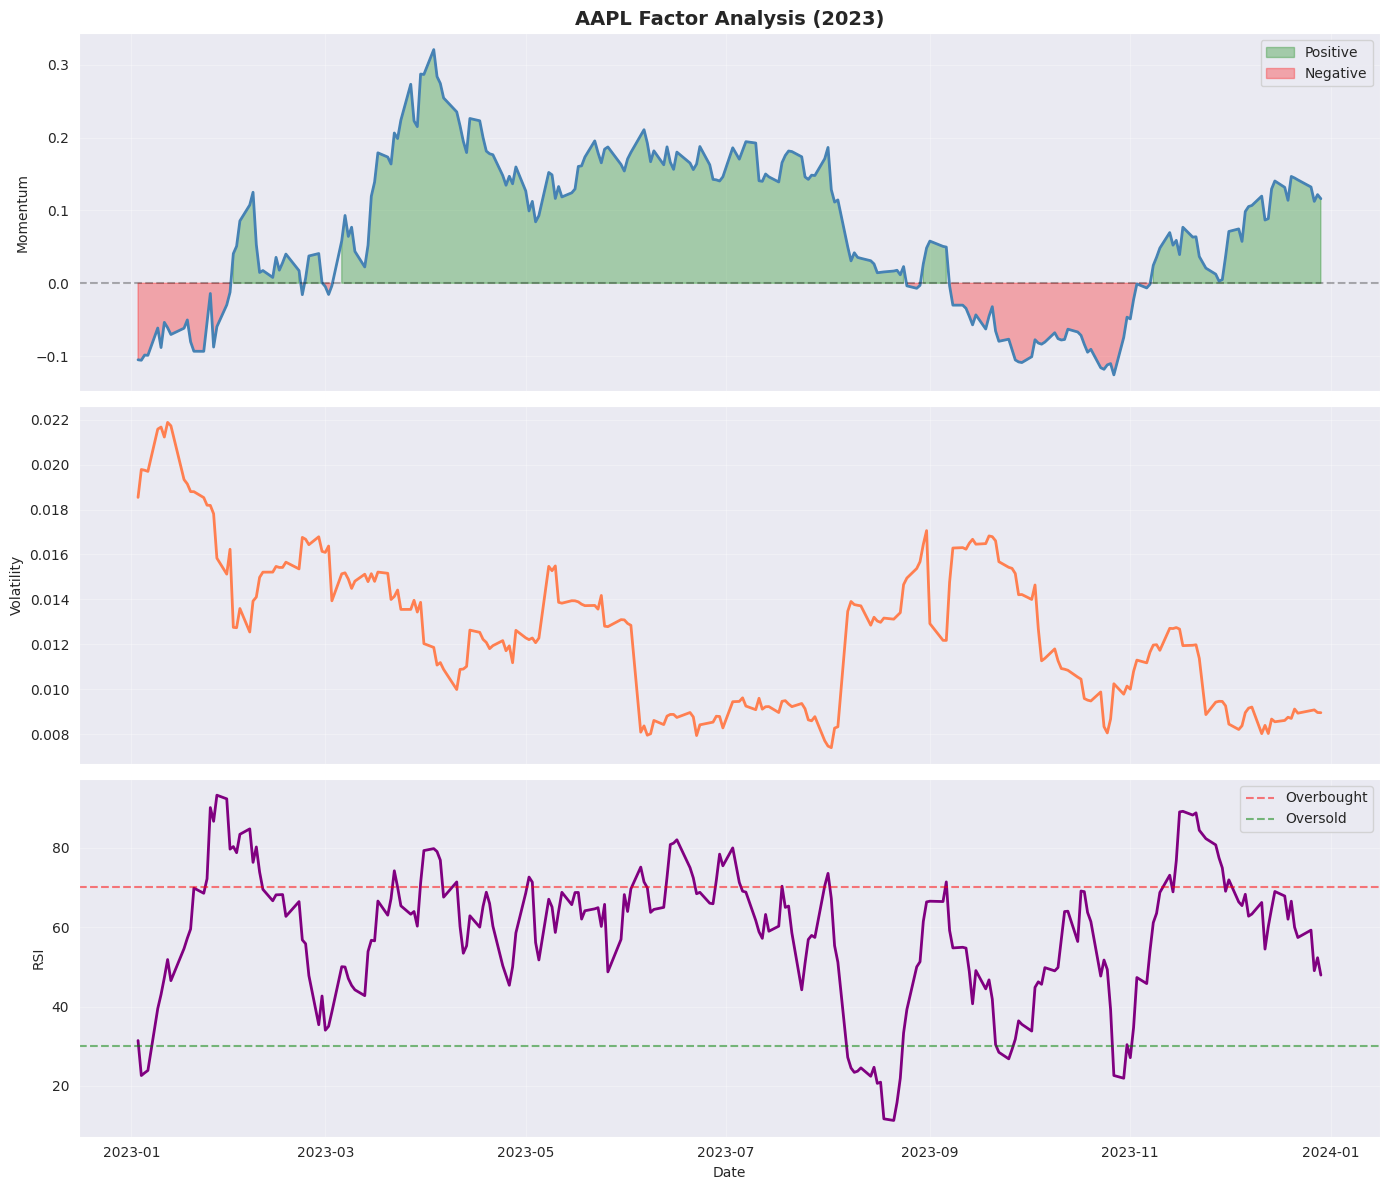

In [11]:
# Pick a stock to analyze (e.g., AAPL)
# Get asset ID for AAPL
aapl = bundle_data.asset_finder.lookup_symbol('AAPL', as_of_date=end_date)

# Extract time series for AAPL
aapl_data = results.xs(aapl, level=1)

# Plot factor evolution
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Momentum over time
axes[0].plot(aapl_data.index, aapl_data['momentum'], linewidth=2, color='steelblue')
axes[0].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[0].fill_between(aapl_data.index, 0, aapl_data['momentum'], 
                      where=aapl_data['momentum']>=0, alpha=0.3, color='green', label='Positive')
axes[0].fill_between(aapl_data.index, 0, aapl_data['momentum'], 
                      where=aapl_data['momentum']<0, alpha=0.3, color='red', label='Negative')
axes[0].set_ylabel('Momentum')
axes[0].set_title('AAPL Factor Analysis (2023)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volatility over time
axes[1].plot(aapl_data.index, aapl_data['volatility'], linewidth=2, color='coral')
axes[1].set_ylabel('Volatility')
axes[1].grid(True, alpha=0.3)

# RSI over time
axes[2].plot(aapl_data.index, aapl_data['rsi'], linewidth=2, color='purple')
axes[2].axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought')
axes[2].axhline(30, color='green', linestyle='--', alpha=0.5, label='Oversold')
axes[2].set_ylabel('RSI')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **Pipeline Setup** - Running pipelines standalone for research
2. **Custom Factors** - Building momentum, volatility, and mean reversion factors
3. **Distribution Analysis** - Understanding factor characteristics
4. **Correlation Analysis** - Finding relationships between factors
5. **Quintile Analysis** - Analyzing factor performance across buckets
6. **Stock Screening** - Finding stocks that meet specific criteria
7. **Time Series Analysis** - Tracking factors over time

## Next Steps

- See `08_alphalens_factor_analysis.ipynb` for factor performance analysis
- See `09_multi_factor_research.ipynb` for combining multiple factors
- Use these techniques to develop and test your own factors
- Integrate successful factors into trading strategies